# Задание 2. Метод опорных векторов. Байесовские классификаторы

## 1. Генерация данных с разным стандартным отклонением

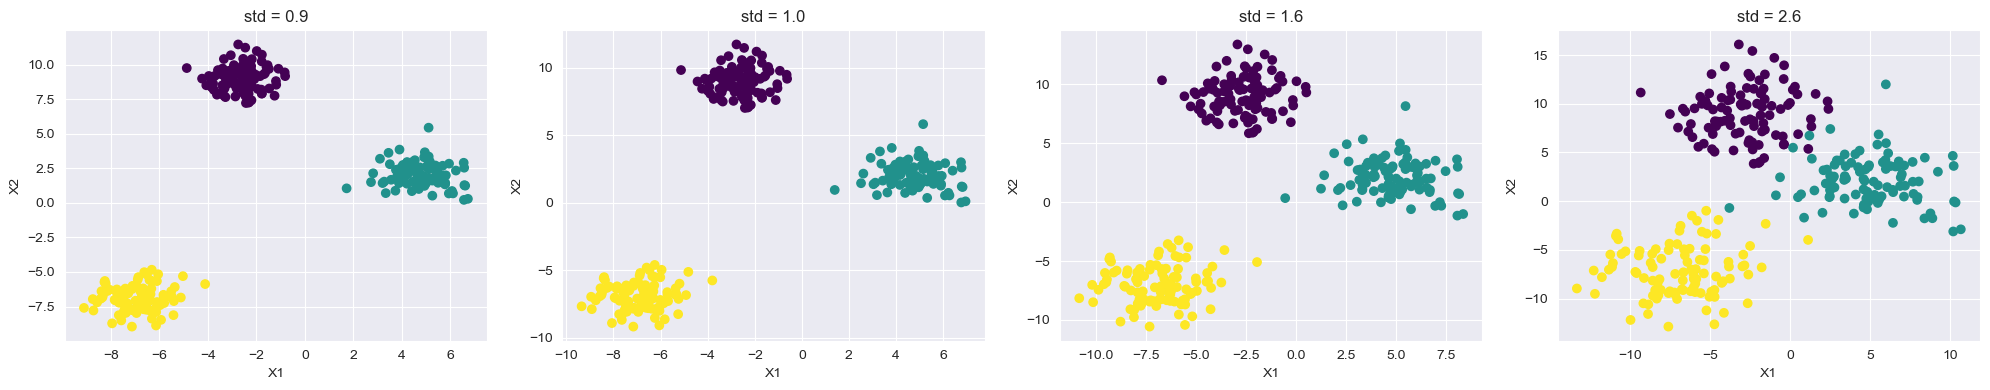

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs

std_values = [0.9, 1.0, 1.6, 2.6]
fig, axes = plt.subplots(1, len(std_values), figsize=(20, 4))

for i, std in enumerate(std_values):
    X, y = make_blobs(n_samples=300, centers=3, cluster_std=std, random_state=42)
    axes[i].scatter(X[:, 0], X[:, 1], c=y, cmap='viridis')
    axes[i].set_title(f"std = {std}")
    axes[i].set_xlabel("X1")
    axes[i].set_ylabel("X2")

plt.tight_layout()
plt.show()


## 2. Обучение SVM-модели и анализ результатов

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

X, y = make_blobs(n_samples=300, centers=3, cluster_std=1.6, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

svm_model = SVC(kernel='rbf', probability=True)
svm_model.fit(X_train, y_train)
y_pred_svm = svm_model.predict(X_test)

## 3. Подбор гиперпараметров для SVM

Лучшие параметры: {'C': 0.1, 'gamma': 'scale', 'kernel': 'linear'}


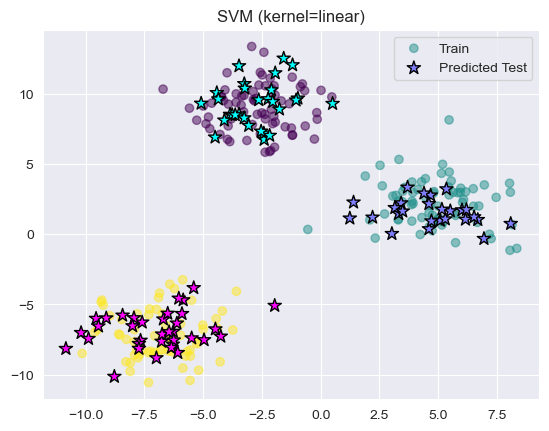

In [3]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'C': [0.1, 1, 10],
    'gamma': ['scale', 0.1, 1],
    'kernel': ['linear', 'rbf', 'poly']
}

grid_svm = GridSearchCV(SVC(probability=True), param_grid, cv=5)
grid_svm.fit(X_train, y_train)

best_svm = grid_svm.best_estimator_
print("Лучшие параметры:", grid_svm.best_params_)

# Визуализация классифицированных точек
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap='viridis', alpha=0.5, label='Train')
plt.scatter(X_test[:, 0], X_test[:, 1], c=best_svm.predict(X_test), cmap='cool', edgecolors='k', marker='*', s=100, label='Predicted Test')
plt.legend()
plt.title(f"SVM (kernel={grid_svm.best_params_['kernel']})")
plt.show()

## 4. Визуализация границ принятия решений и опорных векторов

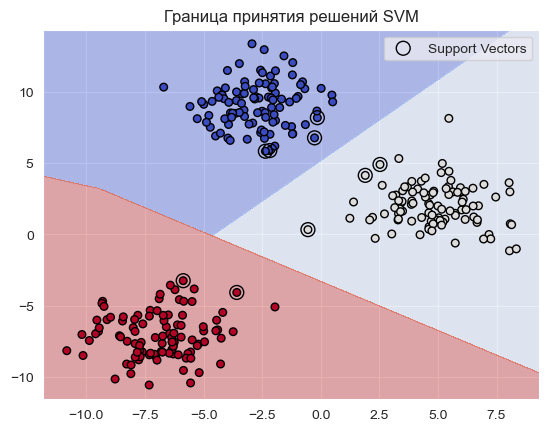

In [4]:
def plot_svm_decision_boundary(model, X, y):
    h = .02
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z, alpha=0.4, cmap='coolwarm')
    plt.scatter(X[:, 0], X[:, 1], c=y, s=30, edgecolors='k', cmap='coolwarm')
    if hasattr(model, 'support_vectors_'):
        plt.scatter(model.support_vectors_[:, 0], model.support_vectors_[:, 1], s=100,
                    facecolors='none', edgecolors='k', label='Support Vectors')
    plt.legend()
    plt.title("Граница принятия решений SVM")
    plt.show()

plot_svm_decision_boundary(best_svm, X, y)

 ## 5. Метрики классификации и матрица несоответствий

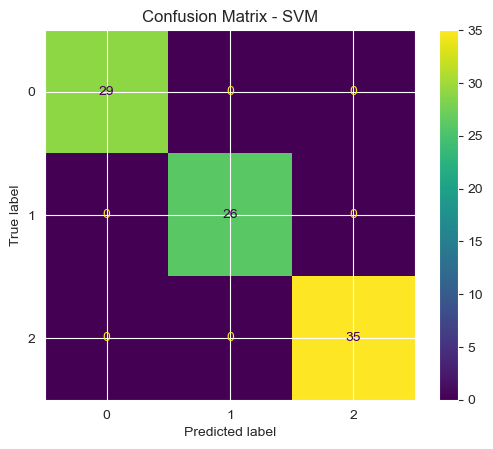

SVM Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1-score: 1.0


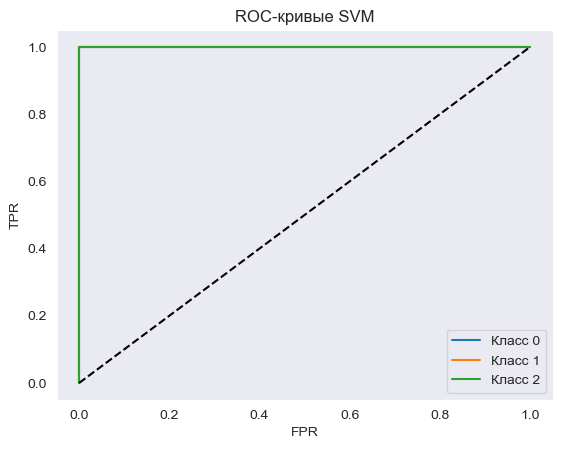

In [5]:
# %%
from sklearn.metrics import (
    confusion_matrix, ConfusionMatrixDisplay,
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    roc_curve
)
from sklearn.preprocessing import label_binarize

def evaluate(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred)
    ConfusionMatrixDisplay(cm).plot()
    plt.title(f"Confusion Matrix - {model_name}")
    plt.show()

    print(f"{model_name} Accuracy:", accuracy_score(y_true, y_pred))
    print("Precision:", precision_score(y_true, y_pred, average='macro'))
    print("Recall:", recall_score(y_true, y_pred, average='macro'))
    print("F1-score:", f1_score(y_true, y_pred, average='macro'))

evaluate(y_test, best_svm.predict(X_test), "SVM")

# ROC-кривые для многоклассовой классификации
y_test_bin = label_binarize(y_test, classes=np.unique(y))
y_score = best_svm.predict_proba(X_test)

fpr, tpr, _ = {}, {}, {}
for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    plt.plot(fpr[i], tpr[i], label=f"Класс {i}")

plt.plot([0, 1], [0, 1], 'k--')
plt.title("ROC-кривые SVM")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.legend()
plt.grid()
plt.show()

## 6. Обзор байесовских классификаторов

 - Наивный Байес (Naive Bayes) — вероятностный классификатор, основанный на теореме Байеса с предположением независимости признаков.
 
Формула:  
 $P(C|X) = \frac{P(X|C)P(C)}{P(X)}$
 
 - Плюсы: прост в реализации, быстро обучается.
 - Минусы: чувствителен к независимости признаков.
 - Применение: спам-фильтры, классификация текста, диагностика заболеваний.

## 7. Обучение и проверка байесовских моделей

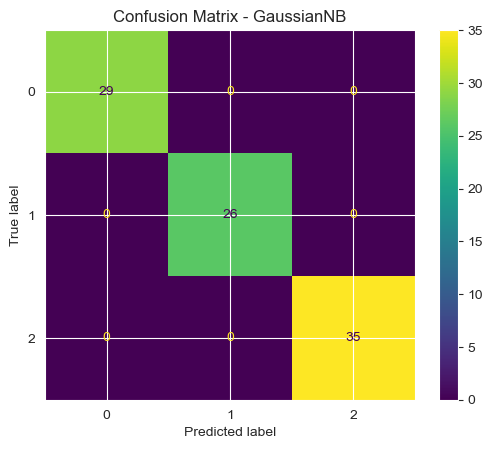

GaussianNB Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1-score: 1.0
MultinomialNB не применим: Negative values in data passed to MultinomialNB (input X)


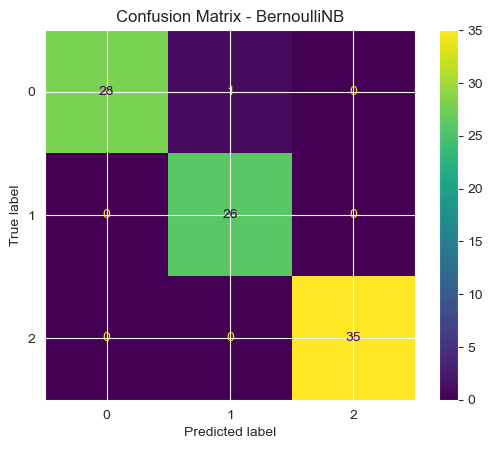

BernoulliNB Accuracy: 0.9888888888888889
Precision: 0.9876543209876543
Recall: 0.9885057471264368
F1-score: 0.9878627386075252


In [6]:
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB

models_nb = {
    "GaussianNB": GaussianNB(),
    "MultinomialNB": MultinomialNB(),
    "BernoulliNB": BernoulliNB()
}

for name, model in models_nb.items():
    try:
        model.fit(X_train, y_train)
        y_pred_nb = model.predict(X_test)
        evaluate(y_test, y_pred_nb, name)
    except Exception as e:
        print(f"{name} не применим: {e}")

## 8. Сравнение SVM и Байесовских классификаторов
Вывод:
- SVM показал высокую точность при правильном подборе ядра и параметров.
- GaussianNB — работает хорошо при нормальном распределении данных.
- MultinomialNB и BernoulliNB — хуже справляются с числовыми признаками, больше подходят для задач с дискретными признаками (например, тексты).
- Визуализация, границы решений и метрики помогают глубже понять поведение моделей.